In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm

from qtt.algorithms.functions import (gauss_ramsey, fit_gauss_ramsey, 
                                      plot_gauss_ramsey_fit)
from qutip import (basis, tensor, sigmaz, sigmax, sigmaz, sigmam, sigmap, 
                   mesolve, identity, Qobj, destroy, qeye, parallel_map)

from qubit_zz_coupling.core import (setup_operators, solve_t1, solve_t2,
                                    plot_t1, plot_t2, 
                                    ramsey_expectation_drive_both,
                                    ramsey_population_drive_both,
                                    ramsey_expectation_drive_sep,
                                    ramsey_population_drive_sep)
from qubit_zz_coupling.utils import  f2w, fq_shift, make_population, ramsey


In [14]:
USE_MP = True # Depends on system

# Define system parameters
SYSTEM_PARAMS_base = {
    "f_q1": 3.2,  # GHz, Qubit 1 frequency (3.2)
    "f_q2": 3.35,  # GHz, Qubit 2 frequency
    "f_tls": 3.2,  # GHz, TLS frequency (resonant with Qubit 1)
    "T1": {"q1": 200, "q2": 250, "tls": 500},  # Relaxation rates
    "T2": {"q1": 150, "q2": 180, "tls": 300},  # Dephasing rates
    "J_zz": 0.01, # Jzz coupling
    "J_tls": 0.05,  # GHz, Coupling strength between Qubit 1 and TLS
    "omega1": 2*np.pi * 0.05, # drive amplitude (sets π/2 duration)
    "omega2": 2*np.pi * 0.05, # drive amplitude (sets π/2 duration)
    "time_points": np.linspace(0, 300, 105),  # Time points in μs
    "ver1": False
}

SYSTEM_PARAMS = SYSTEM_PARAMS_base.copy()

H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

# get times
tlist = SYSTEM_PARAMS["time_points"]

# Single Drive Q1

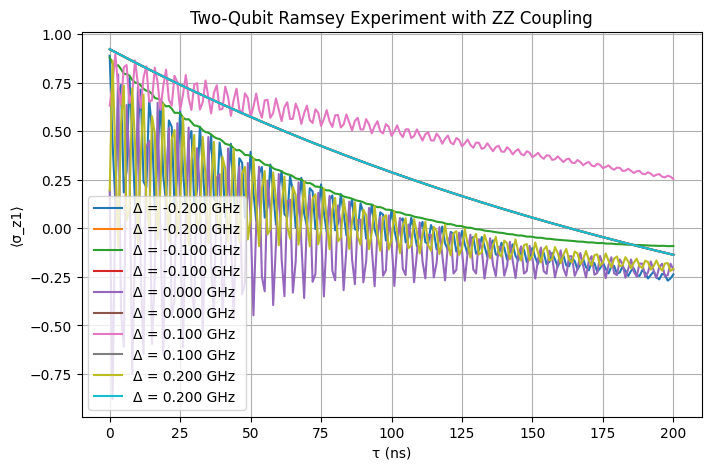

In [23]:
w_q1 = f2w(SYSTEM_PARAMS["f_q1"])

# Example sweep
taus      = np.linspace(0, 200, 201)
detunings = np.linspace(-0.2, +0.2, 5) * 2 * np.pi
t_p = np.pi / (2 * SYSTEM_PARAMS["omega1"])

opts = {"nsteps": 1000000}

def pm(t): # wrapper: define where used
    return ramsey_expectation_drive_sep(1, t, w_d1, t_p, SYSTEM_PARAMS, *setup_operators(SYSTEM_PARAMS), opts=opts)

data = {}
for delta in detunings:
    w_d1 = w_q1 + delta
    if  USE_MP:
        vals = list(parallel_map(pm,taus))
    else:
        vals = [ramsey_expectation_drive_sep(1, tau, w_d1, t_p, SYSTEM_PARAMS, *setup_operators(SYSTEM_PARAMS), opts=opts) for tau in taus]
    data[delta] = vals

plt.figure(figsize=(8, 5))
for delta, vals in data.items():
    plt.plot(taus, vals, label=f"Δ = {delta/(2*np.pi):.3f} GHz")
plt.xlabel("τ (ns)")
plt.ylabel("⟨σ_z1⟩")
plt.title("Two-Qubit Ramsey Experiment with ZZ Coupling")
plt.legend()
plt.grid(True)
plt.show()

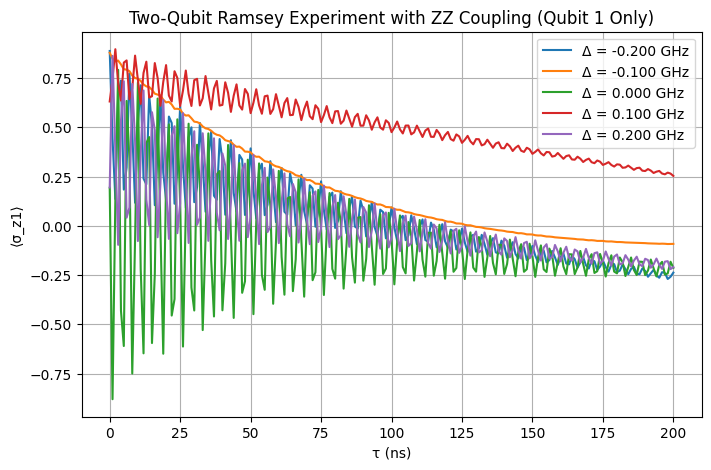

In [24]:
plt.figure(figsize=(8, 5))
for delta, vals in data.items():
    # If vals is a list of tuples, extract only qubit 1 data:
    vals_q1 = [v[0] if isinstance(v, (tuple, list)) else v for v in vals]
    plt.plot(taus, vals_q1, label=f"Δ = {delta/(2*np.pi):.3f} GHz")
plt.xlabel("τ (ns)")
plt.ylabel("⟨σ_z1⟩")
plt.title("Two-Qubit Ramsey Experiment with ZZ Coupling (Qubit 1 Only)")
plt.legend()
plt.grid(True)
plt.show()

# Drive and Fit

In [18]:
w_q1 = f2w(SYSTEM_PARAMS["f_q1"]) 

# Example sweep
taus      = np.linspace(0, 200, 201)
t_p = np.pi / (2 * SYSTEM_PARAMS["omega1"])

opts = {"nsteps": 1000000}

def pm(t):
    return ramsey_population_drive_sep(1, t, w_q1, t_p, SYSTEM_PARAMS, *setup_operators(SYSTEM_PARAMS), opts=opts)

if  USE_MP:
    vals = list(parallel_map(pm,taus))
else:
    vals = [ramsey_population_drive_both(tau, w_q1, w_q1, t_p, SYSTEM_PARAMS, *setup_operators(SYSTEM_PARAMS), opts=opts) for tau in taus]

In [21]:
vals_q1 = (np.array([v[0] if isinstance(v, (tuple, list)) else v for v in vals]))

#pop = make_population(np.array(vals_q1))

first_guess = [0.5, SYSTEM_PARAMS["T2"]["q1"], SYSTEM_PARAMS["f_q1"], 0.0, 0.5]
#first_guess, _ = fit_gauss_ramsey(taus, vals_q1)

fit_par, _ = curve_fit(ramsey, taus, vals_q1, p0=first_guess)
print(fit_par)

[-0.43707262 64.16572514  3.28004835 -1.80075554  0.44542845]


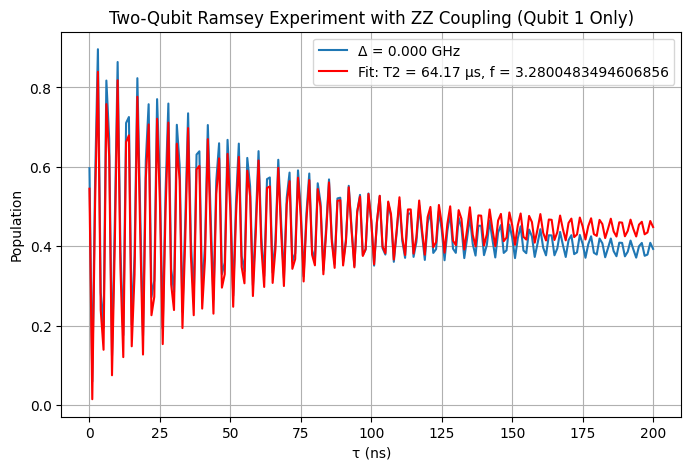

In [22]:
plt.figure(figsize=(8, 5))

plt.plot(taus, vals_q1, label=f"Δ = {0/(2*np.pi):.3f} GHz")
plt.plot(taus, ramsey(taus, *fit_par), 'r-',
            label=f'Fit: T2 = {fit_par[1]:.2f} μs, f = {fit_par[2]}')
plt.xlabel("τ (ns)")
plt.ylabel("Population")
plt.title("Two-Qubit Ramsey Experiment with ZZ Coupling (Qubit 1 Only)")
plt.legend()
plt.grid(True)
plt.show()